Perform preprocessing on multiple images


In [1]:
import nrrd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import cv2
import scipy

import SimpleITK as sitk 
import os 

import ipynb 

# import ipynb.fs.full.imageSubtraction 
from imageSubtractionFunctions import *
# %run imageSubtraction.ipynb


In [66]:
def convertNdArrayToCV2Image(image, resolution = (64,64)):
    """ Converts a numpy array to a cv2 image """
    image = np.array(image, dtype=np.uint8)
    image = cv2.resize(image, resolution)
    return image
def makeAlign(image1,image2):
    image1.SetDirection(image2.GetDirection())
    image1.SetOrigin(image2.GetOrigin())
    image1.SetSpacing(image2.GetSpacing())
    return image1, image2

def isAligned(image1, image2):
    return image1.GetDirection() == image2.GetDirection() and image1.GetOrigin() == image2.GetOrigin() and image1.GetSpacing() == image2.GetSpacing()   

def resampleSizes(wholeHeader, segmentHeader):
    """ 
    Resamples the sitk image to have the same size based on the one with the largest size.
    """
    if wholeHeader.GetSize()[-1] >= segmentHeader.GetSize()[-1]:
        imageLarge = wholeHeader
        imageSmall = segmentHeader
        wholeThenSegmentOrder = True
    else:
        imageLarge = segmentHeader
        imageSmall = wholeHeader 
        wholeThenSegmentOrder = False

    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(imageLarge)  
    resample.SetInterpolator(sitk.sitkNearestNeighbor)  # Choose the interpolation method (linear, nearest neighbor, etc.)
    resample.SetDefaultPixelValue(0)  # Set default pixel value for areas outside the original image

    imageSmall = resample.Execute(imageSmall)

    print(f'imageLarge: {imageLarge.GetSize()}')
    print(f'imageSmall: {imageSmall.GetSize()}')
    

    if wholeThenSegmentOrder:
        return imageLarge, imageSmall # whole, then segment
    else:
        return imageSmall, imageLarge # segment, then whole

In [67]:
def preprocess(wholeHeader, segmentHeader, verbose=True):
    error = False # Error flag to check if there was an error in the preprocessing

    # Check if the images are aligned
    wholeHeader, segmentHeader = makeAlign(wholeHeader, segmentHeader)
    imagesAreAligned = isAligned(wholeHeader, segmentHeader)
    print(f'Are the two images aligned now?: {imagesAreAligned}')

    if not imagesAreAligned:
        error = True
        return None, None, True
    
    # Set the spacing of the image to 1x1x1mm voxel spacing
    wholeHeader.SetSpacing([1,1,1])
    segmentHeader.SetSpacing([1,1,1])
    imagesSpacingAligned = wholeHeader.GetSpacing() == segmentHeader.GetSpacing() 
    print(f'Are the two images aligned in terms of spacing?: {imagesSpacingAligned}')

    if not imagesSpacingAligned:
        error = True
        return None, None, True
    

    imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
    print(f'Are the two images aligned in terms of size?: {imagesSizeAligned}')

    if not imagesSizeAligned:
        wholeHeader, segmentHeader = resampleSizes(wholeHeader, segmentHeader)
        print(f'whole size: {wholeHeader.GetSize()}')
        print(f'segment size: {segmentHeader.GetSize()}')
        imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
        print(f'Are the two images aligned in terms of size now?: {imagesSizeAligned}')
        if not imagesSizeAligned:
            error = True
            return None, None, True


    
    # Convert the images into numpy arrays for further processing, take the transpose as the format is z,y,x
    whole = sitk.GetArrayFromImage(wholeHeader).T
    segment = sitk.GetArrayFromImage(segmentHeader).T

    print(f'Spacing of whole:{whole.shape}')
    print(f'Spacing of segment:{segment.shape}')
    
    # Windowing parameters for the abdomen
    ABDOMEN_UPPER_BOUND = 215
    ABDOMEN_LOWER_BOUND = -135
    window_center = (ABDOMEN_UPPER_BOUND+ABDOMEN_LOWER_BOUND) / 2
    window_width = (ABDOMEN_UPPER_BOUND-ABDOMEN_LOWER_BOUND) / 2

    # Window and resample the whole image
    augmented_whole = window_image_to_adbomen(whole, window_center, window_width)

    # Resample the segment image to the same spacing as the whole image
    augmented_segment = segment

    # plt.imshow(augmented_whole[:, :, 53], cmap="gray")

    # Get the slice indices where the segment is present in 
    segmentedSlices = [] 
    for index in range(augmented_segment.shape[-1]):
        if len(np.unique(augmented_segment[:,:,index])) > 1:
            segmentedSlices.append(index)

    print(f'Segment slice indices:{segmentedSlices}')


    overlay_segment = augmented_whole * augmented_segment
    # print(overlay_segment.shape)
    # print("Dimension of the CT scan is:", image.shape)
    # plt.imshow(overlay_segment[:, :, 133], cmap="gray")

            
    croppedSegment = centerXYOfImage(overlay_segment,augmented_segment,segmentedSlices)
    # croppedSegment = window_image_to_adbomen(croppedSegment, window_center, window_width)
    croppedSegment[croppedSegment<0.1]=0 # Window the image so that the background is completely black for all slices

    croppedSegment = convertNdArrayToCV2Image(croppedSegment)

    if verbose:
        print(f'CroppedSegment shape: {croppedSegment.shape}')
        # Display the segmented image slices 

        columnLen = 10
        rowLen = max(2,croppedSegment.shape[-1] // columnLen + 1) 
        figure,axis = plt.subplots( rowLen, columnLen, figsize=(10, 10))
        
        rowIdx = 0
        for idx in range(croppedSegment.shape[-1]):        
            if idx%columnLen == 0 and idx>0:
                rowIdx += 1
            axis[rowIdx][idx%columnLen].imshow(croppedSegment[:,:,idx], cmap="gray")
            axis[rowIdx][idx%columnLen].axis('off')

        # Turn off the axis of the rest of the subplots
        for i in range(idx+1, rowLen*columnLen):
            if i%columnLen == 0:
                rowIdx += 1
            axis[rowIdx][i%columnLen].axis('off')
        
        # plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

    return whole, croppedSegment, error


CASE523 True
Are the two images aligned now?: True
Are the two images aligned in terms of spacing?: True
Are the two images aligned in terms of size?: False
imageLarge: (512, 512, 199)
imageSmall: (512, 512, 199)
whole size: (512, 512, 199)
segment size: (512, 512, 199)
Are the two images aligned in terms of size now?: True
Spacing of whole:(512, 512, 199)
Spacing of segment:(512, 512, 199)
Segment slice indices:[130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
CroppedSegment shape: (64, 64, 20)


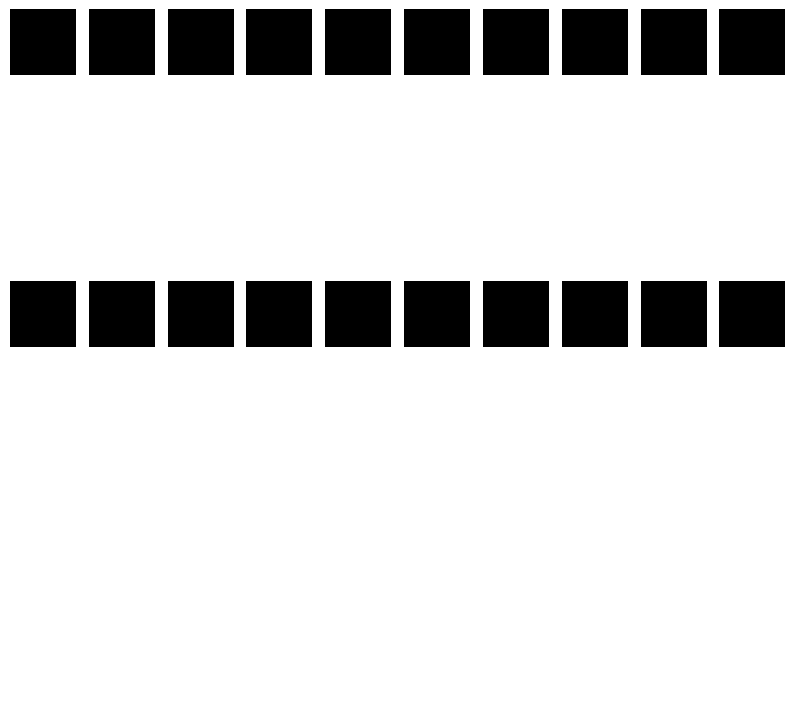

CASE531 True
Are the two images aligned now?: True
Are the two images aligned in terms of spacing?: True
Are the two images aligned in terms of size?: False
imageLarge: (512, 512, 113)
imageSmall: (512, 512, 113)
whole size: (512, 512, 113)
segment size: (512, 512, 113)
Are the two images aligned in terms of size now?: True
Spacing of whole:(512, 512, 113)
Spacing of segment:(512, 512, 113)
Segment slice indices:[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
CroppedSegment shape: (64, 64, 11)


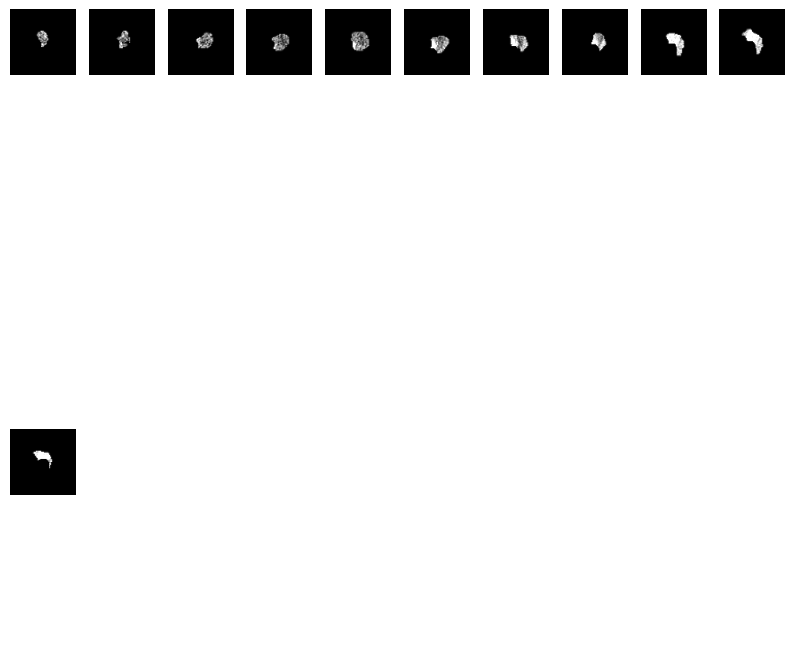

CASE533 True
Are the two images aligned now?: True
Are the two images aligned in terms of spacing?: True
Are the two images aligned in terms of size?: False
imageLarge: (512, 512, 180)
imageSmall: (512, 512, 180)
whole size: (512, 512, 180)
segment size: (512, 512, 180)
Are the two images aligned in terms of size now?: True
Spacing of whole:(512, 512, 180)
Spacing of segment:(512, 512, 180)
Segment slice indices:[28, 29, 30, 31, 32, 33]
CroppedSegment shape: (64, 64, 6)


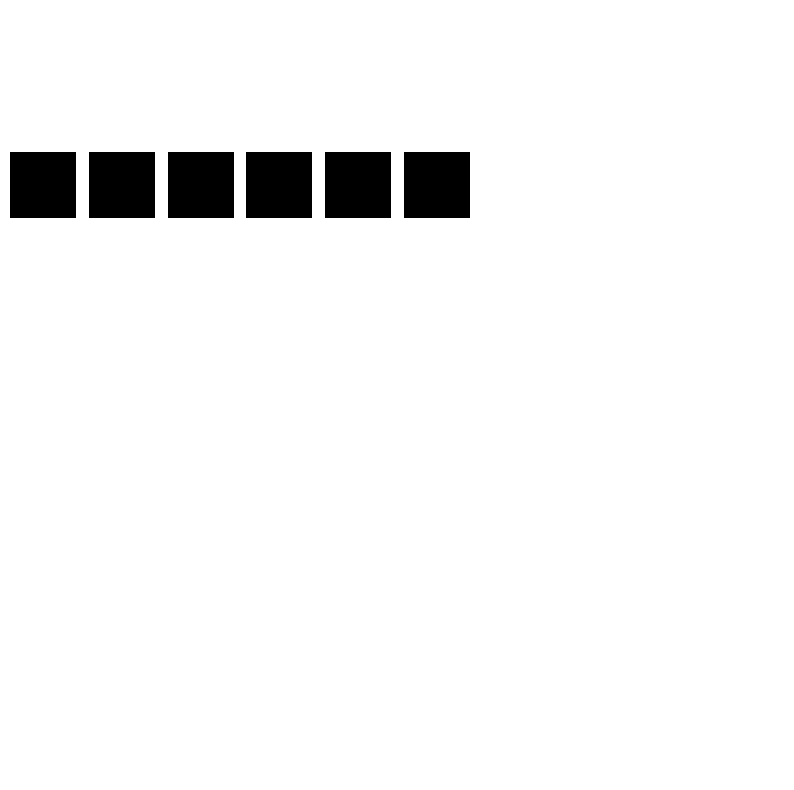

CASE534 True
Are the two images aligned now?: True
Are the two images aligned in terms of spacing?: True
Are the two images aligned in terms of size?: False
imageLarge: (512, 512, 128)
imageSmall: (512, 512, 128)
whole size: (512, 512, 128)
segment size: (512, 512, 128)
Are the two images aligned in terms of size now?: True
Spacing of whole:(512, 512, 128)
Spacing of segment:(512, 512, 128)
Segment slice indices:[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
CroppedSegment shape: (64, 64, 13)


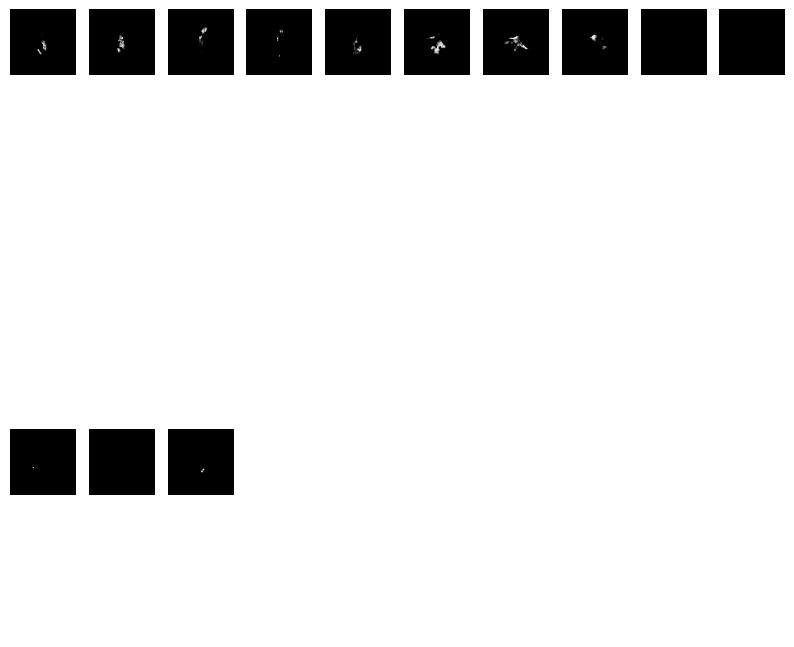

CASE535 True
Are the two images aligned now?: True
Are the two images aligned in terms of spacing?: True
Are the two images aligned in terms of size?: False
imageLarge: (512, 512, 139)
imageSmall: (512, 512, 139)
whole size: (512, 512, 139)
segment size: (512, 512, 139)
Are the two images aligned in terms of size now?: True
Spacing of whole:(512, 512, 139)
Spacing of segment:(512, 512, 139)
Segment slice indices:[73, 74, 75, 76]
CroppedSegment shape: (64, 64, 4)


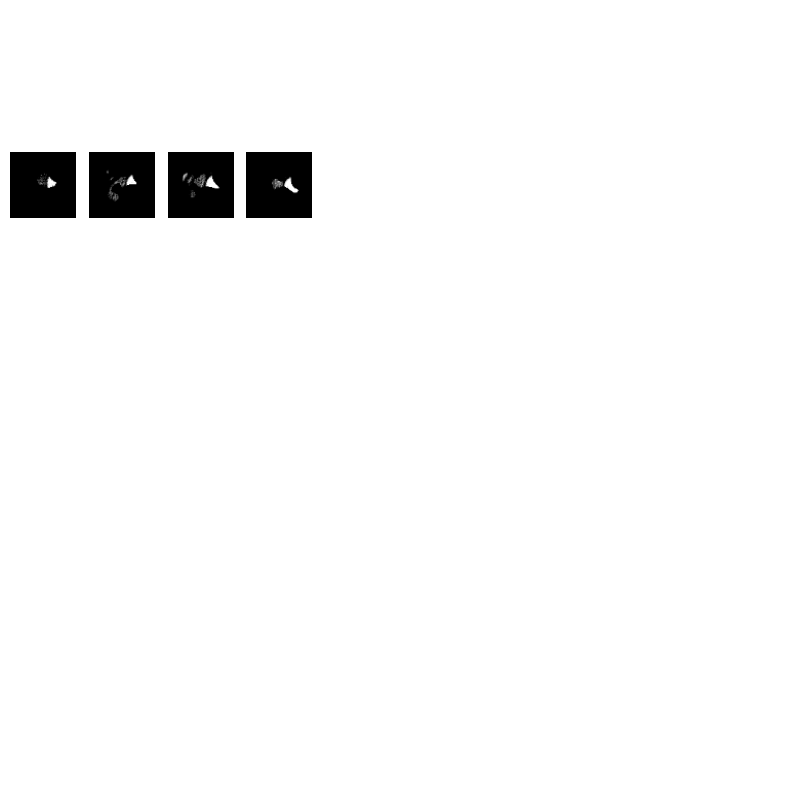

CASE541 True
Are the two images aligned now?: True
Are the two images aligned in terms of spacing?: True
Are the two images aligned in terms of size?: False
imageLarge: (512, 512, 87)
imageSmall: (512, 512, 87)
whole size: (512, 512, 87)
segment size: (512, 512, 87)
Are the two images aligned in terms of size now?: True
Spacing of whole:(512, 512, 87)
Spacing of segment:(512, 512, 87)
Segment slice indices:[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
CroppedSegment shape: (64, 64, 11)


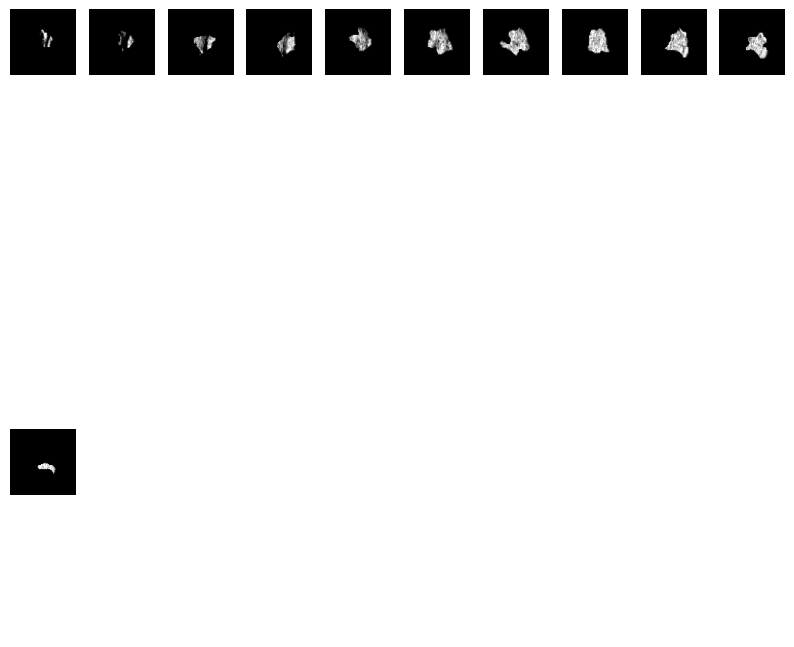

CASE543 True
Are the two images aligned now?: True
Are the two images aligned in terms of spacing?: True
Are the two images aligned in terms of size?: False
imageLarge: (512, 512, 84)
imageSmall: (512, 512, 84)
whole size: (512, 512, 84)
segment size: (512, 512, 84)
Are the two images aligned in terms of size now?: True
Spacing of whole:(512, 512, 84)
Spacing of segment:(512, 512, 84)
Segment slice indices:[15, 16, 17, 18, 19, 20]
CroppedSegment shape: (64, 64, 6)


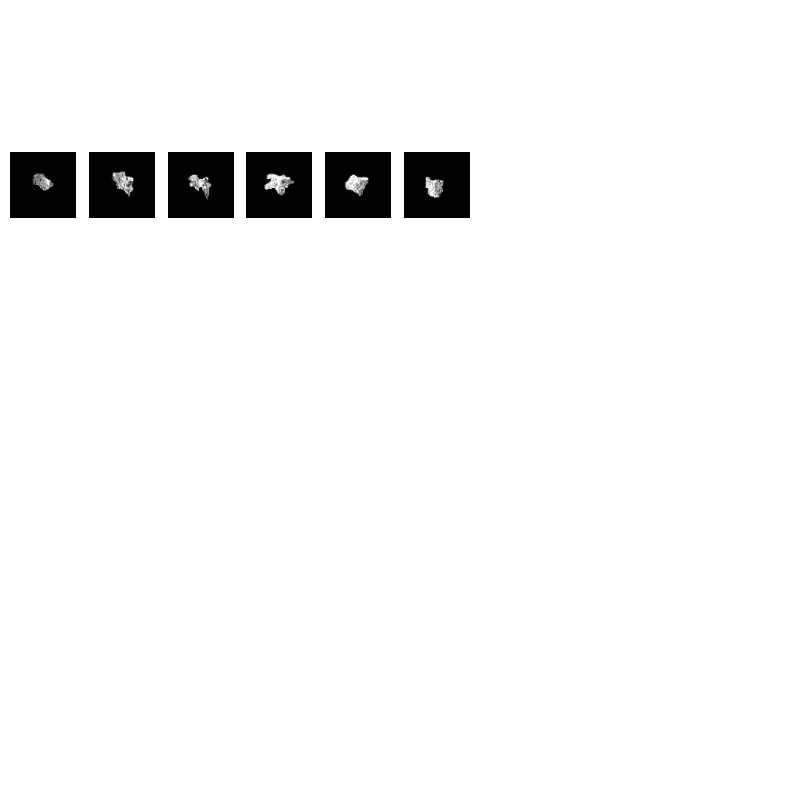

CASE546 True
Are the two images aligned now?: True
Are the two images aligned in terms of spacing?: True
Are the two images aligned in terms of size?: True
Spacing of whole:(512, 512, 83)
Spacing of segment:(512, 512, 83)
Segment slice indices:[31]
CroppedSegment shape: (64, 64)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

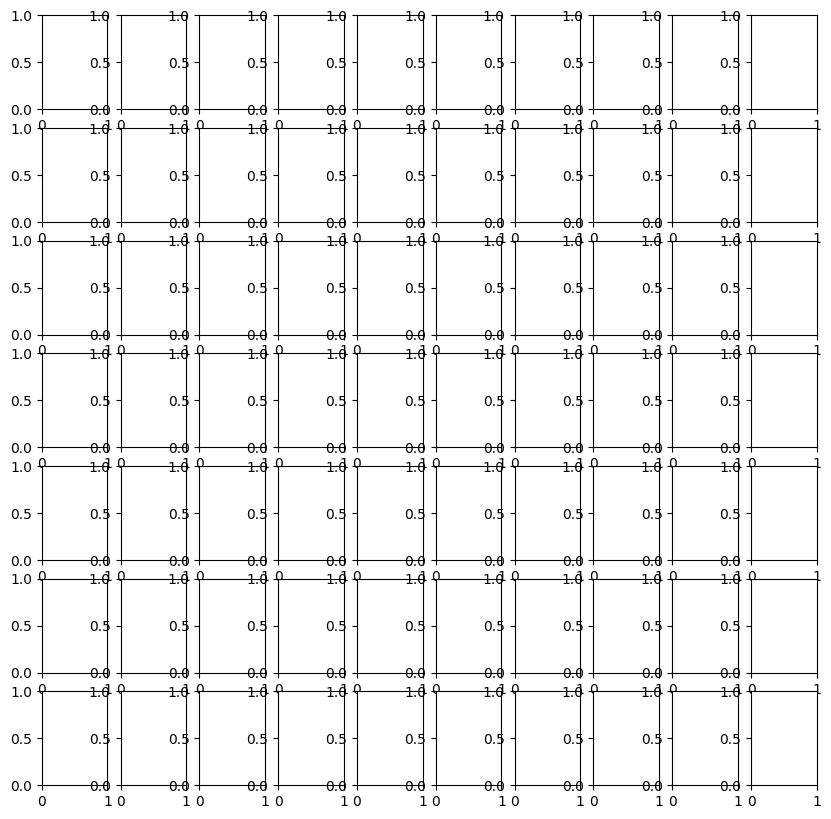

In [68]:
# baseFilepath = 'PDAC-Response/PDAC-Response/ImagingData/Pre-treatment/CASE481_empty'
# segmentFilePath = baseFilepath + '/CASE481_BASE_PRT_TUM_CV.seg.nrrd'
# wholeFilePath = baseFilepath + '/CASE481_BASE_PRT_WHOLE_CT.nrrd' 
# whole, wholeHeader = nrrd.read(wholeFilePath)
# segment, segmentHeader = nrrd.read(segmentFilePath)

allFolders = ['CASE244', 'CASE246', 'CASE247', 'CASE251', 'CASE254', 'CASE256', 'CASE264', 'CASE265', 'CASE270', 'CASE272', 'CASE274', 
              'CASE467', 'CASE468', 'CASE470', 'CASE471', 'CASE472', 'CASE479', 'CASE480', 'CASE482', 'CASE484', 'CASE485', 'CASE494', 'CASE496', 'CASE499', 
              'CASE500', 'CASE505', 'CASE515', 'CASE520', 'CASE523', 'CASE531', 'CASE533', 'CASE534', 'CASE535', 'CASE541', 'CASE543', 'CASE546', 'CASE547', 'CASE548', 'CASE549', 'CASE550', 'CASE551', 'CASE554', 'CASE555', 'CASE557', 'CASE559', 'CASE560', 'CASE562', 'CASE563', 'CASE565', 'CASE568', 'CASE569', 'CASE572', 'CASE574', 'CASE575', 'CASE577', 'CASE578', 'CASE580', 'CASE581', 'CASE585', 'CASE586', 'CASE587', 'CASE588', 'CASE589', 'CASE593', 'CASE594', 'CASE596', 'CASE598', 
              'CASE600', 'CASE602', 'CASE603', 'CASE604', 'CASE605', 'CASE608', 'CASE610', 'CASE611', 'CASE615', 'CASE616', 'CASE622', 'CASE623', 'CASE624', 'CASE630', 'CASE632', 'CASE635']
alreadySeem=['CASE244', 'CASE246', 'CASE247', 'CASE251', 'CASE254', 'CASE256', 'CASE264', 'CASE265', 'CASE270', 'CASE272', 'CASE274', 
              'CASE467', 'CASE468', 'CASE470', 'CASE471', 'CASE472', 'CASE479', 'CASE480', 'CASE482', 'CASE484', 'CASE485', 'CASE494', 'CASE496', 'CASE499', 
              'CASE500', 'CASE505', 'CASE515', 'CASE520']
# alreadySeem = ['CASE244', 'CASE246', 'CASE247', 'CASE251', 'CASE254', 'CASE256', 'CASE263', 'CASE264', 'CASE265', 'CASE270', 'CASE272', 'CASE274', 
#  'CASE467', 'CASE468', 'CASE470', 'CASE471', 'CASE472', 'CASE476', 'CASE479', 'CASE480', 'CASE481_empty', 'CASE482', 'CASE484', 'CASE485', 'CASE488', 'CASE494', 'CASE496', 'CASE499', 
#  'CASE500', 'CASE505', 'CASE515', 'CASE520', 'CASE523', 'CASE525', 'CASE531', 'CASE533', 'CASE534', 'CASE535', 'CASE537', 'CASE539', 'CASE541', 'CASE543', 'CASE546', 'CASE547', 'CASE548', 'CASE549', 'CASE550', 'CASE551', 'CASE554', 'CASE555', 'CASE557', 'CASE559', 'CASE560', 'CASE562', 'CASE563', 'CASE564', 'CASE565', 'CASE568', 'CASE569', 'CASE572', 'CASE574', 'CASE575', 'CASE577', 'CASE578', 'CASE580', 'CASE581', 'CASE585', 'CASE586', 'CASE587', 'CASE588', 'CASE589', 'CASE593', 'CASE594', 'CASE596', 'CASE598', 
#  'CASE600', 'CASE601', 'CASE602', 'CASE603', 'CASE604', 'CASE605', 'CASE608', 'CASE610', 'CASE611', 'CASE615', 'CASE616', 'CASE621', 'CASE622', 'CASE623', 'CASE624', 'CASE629']
baseFilepath = 'PDAC-Response/PDAC-Response/ImagingData/workingdir/'

successes=0
count=0
for folder in os.listdir(baseFilepath):

    if folder in alreadySeem:
        continue 
    count = 0
    for file in os.listdir(os.path.join(baseFilepath,folder)):
        
        if 'segmentation' in file or 'segmention' in file: 
            count+=1
            postSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
            # postSegment = sitk.ReadImage(os.path.join(baseFilepath,folder,file))

        elif 'TUM' in file or 'SMV' in file:
            count+=1
            # segment, segmentHeader = nrrd.read(os.path.join(baseFilepath,folder,file))
        elif file.endswith('CT.nrrd'):
            count+=1
            wholeHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
    
    print('==============================================================')
    print(folder, count==3)
      
    # # For a single case
    # postSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,'CASE246/546151_Tu_segmentation_JM.seg.nrrd'))
    # wholeHeader = sitk.ReadImage(os.path.join(baseFilepath,'CASE246/CASE246_BASE_PRT_WHOLE_CT.nrrd'))

    whole, croppedSegment,error = preprocess(wholeHeader, postSegmentHeader, verbose=True) 
    if error:
        print('Error in preprocessing')
        # successes += 1
        continue
    # count+=1

# print('Successes:', successes)
# print('Total processed:', count)
    
    